In [40]:
import ollama
import numpy as np

In [95]:
c1="""
def linear_interpolate(x0, y0, x1, y1, x):
    if x1 == x0:
        raise ValueError("x0 and x1 cannot be the same value")
    return y0 + (y1 - y0) * ((x - x0) / (x1 - x0))
"""
c2="""
def lin1(initial_x_coordinate, initial_y_coordinate, final_x_coordinate, final_y_coordinate, interpolation_x_coordinate):
    if final_x_coordinate == initial_x_coordinate:
        raise ValueError("initial_x_coordinate and final_x_coordinate cannot be the same value")
    return initial_y_coordinate + (final_y_coordinate - initial_y_coordinate) * ((interpolation_x_coordinate - initial_x_coordinate) / (final_x_coordinate - initial_x_coordinate))
"""
c3="""
def cubic_spline_interpolate(x_values, y_values, x_interp):
    import numpy as np
    
    def cubic_spline_coefficients(x_values, y_values):
        n = len(x_values) - 1
        h = [x_values[i + 1] - x_values[i] for i in range(n)]
        alpha = [3 * (y_values[i + 1] - y_values[i]) / h[i] - 3 * (y_values[i] - y_values[i - 1]) / h[i - 1] for i in range(1, n)]
    
        l = [1] + [0] * n
        mu = [0] * n
        z = [0] * (n + 1)
    
        for i in range(1, n):
            l[i] = 2 * (x_values[i + 1] - x_values[i - 1]) - h[i - 1] * mu[i - 1]
            mu[i] = h[i] / l[i]
            z[i] = (alpha[i - 1] - h[i - 1] * z[i - 1]) / l[i]
    
        l[n] = 1
        z[n] = 0
    
        b = [0] * n
        c = [0] * (n + 1)
        d = [0] * n
        c[n] = 0
    
        for j in range(n - 1, -1, -1):
            c[j] = z[j] - mu[j] * c[j + 1]
            b[j] = (y_values[j + 1] - y_values[j]) / h[j] - h[j] * (c[j + 1] + 2 * c[j]) / 3
            d[j] = (c[j + 1] - c[j]) / (3 * h[j])
    
        return b, c, d
    
    b, c, d = cubic_spline_coefficients(x_values, y_values)
    n = len(x_values) - 1

    def spline(x):
        for i in range(n):
            if x_values[i] <= x <= x_values[i + 1]:
                dx = x - x_values[i]
                return y_values[i] + b[i] * dx + c[i] * dx**2 + d[i] * dx**3
        return None

    return np.array([spline(x) for x in x_interp])
"""
c4="""
def linear_interpolate(x_list,y_list,x):
    return 0.5*(x_list[0]+x_list[1])    
"""

In [96]:
z1=ollama.embeddings(model='mxbai-embed-large', prompt=c1)['embedding']
z2=ollama.embeddings(model='mxbai-embed-large', prompt=c2)['embedding']
z3=ollama.embeddings(model='mxbai-embed-large', prompt=c3)['embedding']
z4=ollama.embeddings(model='mxbai-embed-large', prompt=c4)['embedding']

In [97]:
z1/=np.sqrt(np.dot(z1,z1))
z2/=np.sqrt(np.dot(z2,z2))
z3/=np.sqrt(np.dot(z3,z3))
z4/=np.sqrt(np.dot(z4,z4))

In [98]:
print("{:.2g} {:.2g} {:.2g}".format(np.dot(z1,z2),np.dot(z1,z3),np.dot(z1,z4)))
print("{:.2g} {:.2g}".format(np.dot(z2,z3),np.dot(z2,z4)))
print("{:.2g}".format(np.dot(z3,z4)))

0.87 0.69 0.83
0.66 0.72
0.67


In [61]:
import matplotlib.pyplot as plt

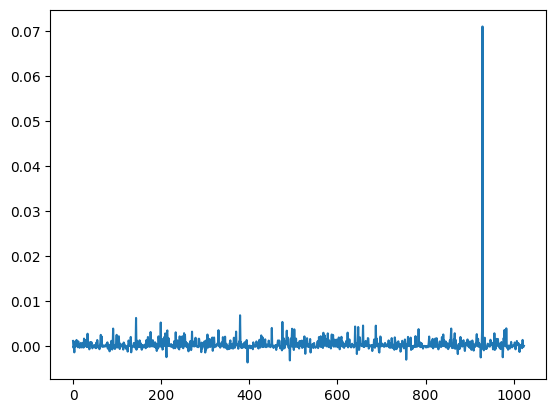

In [63]:
plt.plot(z2*z1)

In [130]:
from transformers import RobertaTokenizer, RobertaModel,LongformerTokenizer,LongformerModel
import torch
from sklearn.metrics.pairwise import cosine_similarity

# Initialize tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('microsoft/codebert-base')
model = RobertaModel.from_pretrained('microsoft/codebert-base')

# Initialize tokenizer and model
tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')
model = LongformerModel.from_pretrained('allenai/longformer-base-4096')


def get_embedding(code):
    inputs = tokenizer(code, return_tensors='pt')
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1)

def get_pooled_embedding(code, max_length=512):
    inputs = tokenizer(code, return_tensors='pt', truncation=True, max_length=max_length)
    outputs = model(**inputs)
    attention_mask = inputs['attention_mask']
    embeddings = outputs.last_hidden_state
    
    # Apply attention mask to ignore padding tokens
    mask_expanded = attention_mask.unsqueeze(-1).expand(embeddings.size()).float()
    
    # Sum embeddings and attention mask
    sum_embeddings = torch.sum(embeddings * mask_expanded, dim=1)
    sum_mask = torch.clamp(mask_expanded.sum(dim=1), min=1e-9)
    
    # Compute mean pooled embedding
    pooled_embedding = sum_embeddings / sum_mask
    return pooled_embedding

# Example functions
func1 = """
def add(a, b):
    return a + b
"""

func2 = """
def sum_numbers(x, y):
    return x + y
"""

# Get embeddings
embedding1 = get_pooled_embedding(c1)
embedding2 = get_pooled_embedding(c4)

# Calculate cosine similarity
similarity = cosine_similarity(embedding1.detach().numpy(), embedding2.detach().numpy())
print(f'Similarity: {similarity[0][0]}')


/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/597M [00:00<?, ?B/s]

Input ids are automatically padded from 89 to 512 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 44 to 512 to be a multiple of `config.attention_window`: 512


Similarity: 0.9750500321388245


In [135]:
from transformers import LongformerTokenizer, LongformerModel
import torch
from sklearn.metrics.pairwise import cosine_similarity
import ast
from zss import simple_distance, Node

# Initialize tokenizer and model
tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')
model = LongformerModel.from_pretrained('allenai/longformer-base-4096')

def get_embedding(code, max_length=4096):
    inputs = tokenizer(code, return_tensors='pt', truncation=True, max_length=max_length)
    outputs = model(**inputs)
    attention_mask = inputs['attention_mask']
    embeddings = outputs.last_hidden_state
    mask_expanded = attention_mask.unsqueeze(-1).expand(embeddings.size()).float()
    sum_embeddings = torch.sum(embeddings * mask_expanded, dim=1)
    sum_mask = torch.clamp(mask_expanded.sum(dim=1), min=1e-9)
    pooled_embedding = sum_embeddings / sum_mask
    return pooled_embedding

def ast_to_tree(node):
    if isinstance(node, ast.AST):
        node_name = type(node).__name__
        tree_node = Node(node_name)
        for field, value in ast.iter_fields(node):
            child = ast_to_tree(value)
            if child:
                tree_node.addkid(child)
        return tree_node
    elif isinstance(node, list):
        list_node = Node("list")
        for item in node:
            child = ast_to_tree(item)
            if child:
                list_node.addkid(child)
        return list_node
    return None

def sigmoid(x):
    return 1 / (1 + x)

def compare_functions(func1, func2):
    # Get embeddings
    embedding1 = get_embedding(func1)
    embedding2 = get_embedding(func2)
    
    # Calculate cosine similarity
    similarity = cosine_similarity(embedding1.detach().numpy(), embedding2.detach().numpy())[0][0]
    print('similarity', similarity)
    
    # Parse functions into ASTs
    tree1 = ast_to_tree(ast.parse(func1))
    tree2 = ast_to_tree(ast.parse(func2))
    
    # Calculate tree edit distance
    tree_similarity = sigmoid(simple_distance(tree1, tree2))
    print('tree_similarity', tree_similarity)
    
    # Combine similarity scores (you may need to adjust weights based on your preference)
    combined_similarity = similarity * tree_similarity
    
    return combined_similarity

# Example functions
c1 = """
def linear_interpolate(x0, y0, x1, y1, x):
    if x1 == x0:
        raise ValueError("x0 and x1 cannot be the same value")
    return y0 + (y1 - y0) * ((x - x0) / (x1 - x0))
"""

c4 = """
def linear_interpolate(x_list, y_list, x):
    return 0.5 * (x_list[0] + x_list[1])
"""

# Compare functions
similarity_score = compare_functions(c1, c2)
print(f'Combined similarity score: {similarity_score:.2f}')


/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


similarity 0.96444744
tree_similarity 1.0
Combined similarity score: 0.96


In [141]:
import clang.cindex

# Initialize Clang
clang.cindex.Config.set_library_file('/Library/Developer/CommandLineTools/usr/lib/libclang.dylib')
index = clang.cindex.Index.create()

# Parse the C++ code
code = """
int main() {
    int a = 10;
    int b = 20;
    int c = a + b;
    return 0;
}
"""
translation_unit = index.parse('example.cpp', args=['-std=c++11'], unsaved_files=[('example.cpp', code)])

# Walk the AST
def walk_ast(node, indent=0):
    print(' ' * indent + str(node.spelling) + ' ' + str(node.kind))
    for child in node.get_children():
        walk_ast(child, indent + 2)

walk_ast(translation_unit.cursor)


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/clang/cindex.py", line 3928, in register_function
    if Config.library_file:
           ^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/ctypes/__init__.py", line 389, in __getattr__
    func = self.__getitem__(name)
           ^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/ctypes/__init__.py", line 394, in __getitem__
    func = self._FuncPtr((name_or_ordinal, self))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: dlsym(0x9248a420, clang_CXXMethod_isCopyAssignmentOperator): symbol not found

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/fo

In [2]:
import clang.cindex

# Set the correct path to libclang.dylib
clang.cindex.Config.set_library_file('/opt/homebrew/opt/llvm/lib/libclang.dylib')

# Initialize Clang Index
index = clang.cindex.Index.create()

# C++ code to parse
code = """
int main() {
    int a = 10;
    int b = 20;
    int c = a + b;
    return 0;
}
"""

# Parse the C++ code
translation_unit = index.parse('example.cpp', args=['-std=c++11'], unsaved_files=[('example.cpp', code)])

# Function to walk and print the AST
def walk_ast(node, indent=0):
    print(' ' * indent + str(node.spelling) + ' ' + str(node.kind))
    for child in node.get_children():
        walk_ast(child, indent + 2)

# Walk and print the AST starting from the translation unit cursor
walk_ast(translation_unit.cursor)


Exception: library file must be set before before using any other functionalities in libclang.

In [1]:
import clang.cindex

# Set the path to libclang
clang.cindex.Config.set_library_file('/opt/homebrew/opt/llvm/lib/libclang.dylib')

# Initialize Clang Index
index = clang.cindex.Index.create()

# Parse the C++ file
file_path = 'example.cpp'  # Path to your C++ file
translation_unit = index.parse(file_path, args=['-std=c++11'])

# Function to extract function code
def get_function_code(source, start_line, start_col, end_line, end_col):
    lines = source.splitlines()
    function_lines = lines[start_line-1:end_line]
    function_lines[0] = function_lines[0][start_col-1:]
    function_lines[-1] = function_lines[-1][:end_col-1]
    return '\n'.join(function_lines)

# Read the source code
with open(file_path, 'r') as file:
    source_code = file.read()

# Function to walk the AST and extract function definitions
def walk_ast(node, source_code):
    if node.kind == clang.cindex.CursorKind.FUNCTION_DECL:
        start = node.extent.start
        end = node.extent.end
        function_code = get_function_code(source_code, start.line, start.column, end.line, end.column)
        print(f'Function: {node.spelling}\n{function_code}\n')

    for child in node.get_children():
        walk_ast(child, source_code)

# Walk the AST starting from the translation unit cursor
walk_ast(translation_unit.cursor, source_code)


TranslationUnitLoadError: Error parsing translation unit.

In [3]:
import subprocess
import argparse
import ollama

def get_git_log():
    result = subprocess.run(['git', 'log', '-p',], capture_output=True, text=True)
    if result.returncode != 0:
        raise Exception("Error running git log -p")
    return result.stdout

def split_into_chunks(text, chunk_size=1000):
    lines = text.splitlines()
    chunks = []
    current_chunk = []
    current_size = 0
    for line in lines:
        current_chunk.append(line)
        current_size += len(line)
        if current_size >= chunk_size:
            chunks.append('\n'.join(current_chunk))
            current_chunk = []
            current_size = 0
    if current_chunk:
        chunks.append('\n'.join(current_chunk))
    return chunks

def analyze_chunk_with_ollama(chunk):
    prompt = f"Analyze the following code for potential memory defects:\n\n{chunk}\n\nAre there any memory defects in the code above? Please explain."
    response = ollama.chat(model="deepseek-coder:33b", messages=[{"role": "user", "content": prompt}])
    return response['choices'][0]['message']['content']

def analyze_git_log_for_memory_defects():
    git_log = get_git_log()
    chunks = split_into_chunks(git_log)
    all_results = []
    for chunk in chunks:
        try:
            result = analyze_chunk_with_ollama(chunk)
            all_results.append(result)
        except Exception as e:
            print(f"Error analyzing chunk: {e}")
    return all_results

def main():
    parser = argparse.ArgumentParser(description='Analyze git log for potential memory defects.')
    args = parser.parse_args()
    
    results = analyze_git_log_for_memory_defects()
    for result in results:
        print(result)

if __name__ == '__main__':
    main()


usage: ipykernel_launcher.py [-h]
ipykernel_launcher.py: error: unrecognized arguments: -f /Users/ww5/Library/Jupyter/runtime/kernel-720b7cd9-2abe-4101-a27b-3c2743b0e952.json


SystemExit: 2

/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
